In [104]:
from dotenv import load_dotenv
import os

load_dotenv()
if os.getenv("OPENAI_API_KEY"):
    print("Cargado correctamente API")

Cargado correctamente API


In [105]:
from langchain_openai import ChatOpenAI

MODEL = "gpt-4o-mini"
llm = ChatOpenAI(model=MODEL,temperature=0.4)

In [128]:
#tools
# tool fecha actual
from datetime import datetime, date
from langchain_core.tools import tool

@tool
def current_date_time():
    """
    Tool: cuando el usuario hable de tiempo usa esta herramienta para determinar la fecha actual,
    realiza las operaciones necesarias para cumplir con la fecha que pide el usuario
    """
    today = date.today().isoformat()
    current_time = datetime.now().strftime("%Y-%m-%dT%H:%M:%S-05:00")
    # "current_date":today, 
    return {
        "current_date":today,
        "current_time":current_time
    }

In [127]:
tools = [current_date_time]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [109]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MyState(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]
    intencion: str
    summary: str

In [129]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def identificar_intencion(state: MyState) -> dict:
    system_promp = """Tu tarea es identificar y clasificar la intención del usuario a partir de la conversación proporcionada, usando la siguiente lista de posibles intenciones:

    agendar_cita: El usuario desea reservar o programar una nueva cita.
    consultar_cita: El usuario quiere obtener información sobre una cita ya existente, como la hora o el lugar.
    reagendar_cita: El usuario busca cambiar la fecha o la hora de una cita previamente programada.
    otra: cuando el usuario realiza una conversacion fuera del contexto

    Debes responder solamente con una intención de esta lista: [agendar_cita, consultar_cita, reagendar_cita, otra]
    No agregues mas palabras
    """
    resp = llm.invoke([SystemMessage(content=system_promp)] + state["messages"])
    print(resp)
    intencion = resp.content.strip().lower()
    return {"messages": state.get("messages","") + [f"intencion identificada: {intencion}"], "intencion": intencion, "summary": state.get("summary","") + f"Intención detectada: {intencion}"}

In [111]:
def consultar_cita(state: MyState) -> dict:
    system_prompt = """Eres una base de datos que tienes agendado citas, cuado el usuario te pida una consulta de cita tu vas a responder con la fecha y la hora de forma simulada.    
    """

    resp = llm.invoke([SystemMessage(content=system_prompt)] + state.get("messages",""))
    cita = resp.content
    return {"messages": state["messages"] + [f"{cita}"],
            "intecion": state["intencion"],
            "summary": state.get("summary","") + f"Cita consultada para el dia de {cita}"
            }

In [132]:
def agendar_cita(state: MyState) -> dict:
    system_prompt = """Eres un asistsente útil que agendas citas, tu principal rol es simular que creas citas. Utiliza la herramienta (tool) current_date_time para determinar la fecha actual"""

    resp = llm_with_tools.invoke([SystemMessage(content=system_prompt)] + state.get("messages",""))
    agenda = resp.content
    print(resp)
    return {"messages": state["messages"] + [resp],
            "intecion": state["intencion"],
            "summary": state.get("summary","") + f"Cita consultada para el dia de {agenda}"
    }

In [122]:
def otra(state: MyState) -> dict:
    system_prompt = """Eres un asistsente útil, sigue la conversacion del usuario de forma natural"""

    resp = llm.invoke([SystemMessage(content=system_prompt)] + state.get("messages",""))
    agenda = resp.content
    return {"messages": state["messages"] + [f"{agenda}"],
            "intecion": state["intencion"],
            "summary": state.get("summary","") + f"Cita consultada para el dia de {agenda}"
    }

In [114]:
#funcion determinar ruta
def determinar_ruta(state: MyState) -> str:
    intencion = state['intencion']
    if intencion == "consultar_cita":
        return "consultar_cita"
    elif intencion == "agendar_cita":
        return "agendar_cita"
    else: 
        intencion == "otra"
        return "otra"


In [115]:
import sqlite3

db_path="state_db/exmple.db"
conn=sqlite3.connect(db_path,check_same_thread = False)

In [116]:
#checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver(conn)

In [140]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

#Define Grafo
builder = StateGraph(MyState)

#Define nodos
builder.add_node('identificar_intencion',identificar_intencion)
builder.add_node('consultar_cita',consultar_cita)
builder.add_node('agendar_cita',agendar_cita)
builder.add_node('otra',otra)
builder.add_node("tools", ToolNode(tools))

#Define la secuencia de los agentes para este caso 
builder.add_edge(START,'identificar_intencion')
builder.add_conditional_edges("identificar_intencion",determinar_ruta, {
        "consultar_cita": "consultar_cita",
        "agendar_cita": "agendar_cita",
        "otra": 'otra'
    })
#condicional para ejecutar herramientas (tools)
builder.add_conditional_edges(
    "agendar_cita",
    tools_condition,
    {
        "tools": "tools",
        END: END 
    }
)
builder.add_edge("tools", "agendar_cita")
builder.add_edge('consultar_cita',END)
builder.add_edge('agendar_cita',END)
builder.add_edge('otra',END)

#compilar
graph = builder.compile(checkpointer=memory)

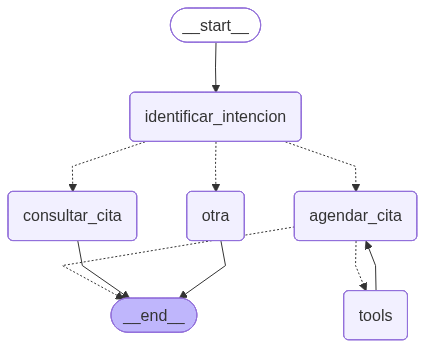

In [141]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [142]:
config = {"configurable": {"thread_id":"5"}}

In [143]:
content = "puedes agendarme una cita medica para mañana"
messages = [HumanMessage(content=content)]
messages = graph.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

content='agendar_cita' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 350, 'total_tokens': 354, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CSVMROyqQXRrXN5EARL5DjgroyFKN', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--e1fab500-f1bf-4874-8e28-8df31d621648-0' usage_metadata={'input_tokens': 350, 'output_tokens': 4, 'total_tokens': 354, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
content='' additional_kwargs={'tool_calls': [{'id': 'call_tzPSDK8WofJQRsHmD3I5MOsj', 'function': {'arguments': '{}', 'name': 'current_date_time'}, 'type': 'function'}], 'refusal': None} response_metada

In [121]:
config = {"configurable": {"thread_id": "2"}}
graph_state = graph.get_state(config)
graph_state

ValueError: No checkpointer set

In [ ]:
messages


{'messages': [HumanMessage(content='puedes agendarme una cita medica para mañana', additional_kwargs={}, response_metadata={}, id='2e064b38-3f07-4262-b8c1-4f25f4d93cb0'),
  HumanMessage(content='intencion identificada: agendar_cita', additional_kwargs={}, response_metadata={}, id='a732557d-aaaa-4314-9c0f-75f81e5e4685'),
  HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='5b1f5d9b-c405-4144-a462-ecfa43b7eb8c'),
  HumanMessage(content='puedes agendarme una cita médica para mañana', additional_kwargs={}, response_metadata={}, id='8691dcab-afc1-49ea-b131-af39dd79d892'),
  HumanMessage(content='intencion identificada: agendar_cita', additional_kwargs={}, response_metadata={}, id='4517204d-2740-44bc-a80e-1f15bfa5804b'),
  HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='11c86ff9-1318-4d89-acc2-6957835541bc'),
  HumanMessage(content='puedes agendarme una cita medica para mañana', additional_kwargs={}, response_metadata={}, id='677b777f-e7a9-47d5-

In [ ]:
graph.reset()

state = {
    "messages": [HumanMessage(content="puedes agendarme una cita médica para mañana")],
    "intencion": "",
    "summary": ""
}

result = graph.invoke(state,config)

for m in result["messages"]:
    print(f"{m.type.upper()}: {m.content}\n")

AttributeError: 'CompiledStateGraph' object has no attribute 'reset'